In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from utils import *

Populating the interactive namespace from numpy and matplotlib


This notebook focuses on the three Running tasks before Jumper tasks for all three rats. 

# visualize trials (goal and trajectory)

In [2]:
rat1_preBMI = torch.load('./data/Running/jumper_after_run/wr112_0905_preJumper_dict')
rat2_preBMI = torch.load('./data/Running/jumper_after_run/wr118_0821_preJumper_dict')
rat3_preBMI = torch.load('./data/Running/jumper_after_run/wr121_0927_preJumper_dict')

In [3]:
# each key is a trial number
rat1_preBMI.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [4]:
# for each trial, there are 3 variables: `t`, `pos` and `goal`
rat1_preBMI[0].keys()

dict_keys(['t', 'pos', 'goal'])

In [5]:
# select which animal we want to look at
@interact(data={'rat1_Running': rat1_preBMI, 'rat2_Running': rat2_preBMI, 'rat3_Running': rat3_preBMI})
def assign_preBMI(data):
    global preBMI
    global goal_radius
    preBMI = data
    # if rat3_preBMi, use goal_radius = 10
    if data == rat3_preBMI:
        goal_radius = 10
    else:
        goal_radius = 15

interactive(children=(Dropdown(description='data', options={'rat1_Running': {0: {'t': array([5. , 5.1, 5.2, 5.…

In [6]:
# select which trial we want to look at
@interact(trial=(0, max(list(preBMI.keys()))-1))
def plot_preBMI_trial(trial=0):
    _pos = preBMI[trial]['pos']
    _goal = preBMI[trial]['goal']
    goal_center = (_goal[0], -_goal[1])
    if _pos.shape[0] < 2:
        print('no data')
        return
    plt.plot(_pos[:, 0], -_pos[:, 1], '-', color='gray')
    plt.plot(_pos[-1, 0], -_pos[-1, 1], 'o', color='gray', markersize=15)
    plot_goal(plt.gca(), goal_center, goal_radius=goal_radius)
    plt.show()

interactive(children=(IntSlider(value=0, description='trial', max=97), Output()), _dom_classes=('widget-intera…

# visualize actual location and decoded location frame by frame

### rat1

In [7]:
rat1_pos = np.load('./data/Running/jumper_after_run/wr112_0905_RUN_Pos.npy')
rat1_pv  = np.load('./data/Running/jumper_after_run/wr112_0905_RUN_PV.npy')
rat1_pos.shape, rat1_pv.shape

((18546, 2), (18546, 157))

In [8]:
# rat1_pos = gaussian_filter1d(rat1_pos, 10, axis=0)

In [9]:
# load DNN model, place unit id, and length of bins for each decoding frame
rat1_model, rat1_neuron_idx, B_bins = load_pretrained_model(rat='rat1', task='Jumper')

In [10]:
# convert pv (n_samples, n_neurons) to spv for decoding, spv: (n_samples, B_bins, n_neurons)
rat1_spv = pv_2_spv(rat1_pv, B_bins=B_bins)
rat1_spv.shape

(18497, 50, 157)

In [11]:
dec_pos = decode(rat1_model, rat1_spv, rat1_neuron_idx, cuda=True, mimic_realtime=False, smooth=True)

In [12]:
rat1_pos.shape[0] - dec_pos.shape[0]

49

In [13]:
r2_score(rat1_pos[49:], dec_pos)

0.8286902802506413

In [14]:
trial_start = np.array([rat1_preBMI[i]['t'][0] for i in range(len(rat1_preBMI))])
trial_end = np.array([rat1_preBMI[i]['t'][-1] for i in range(len(rat1_preBMI))])

In [15]:
@interact(i=(0, len(rat1_pos)-1))
def plot_traj(i=0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 10]})
    current_t = convert_frame_to_time(i)
    ax[0].set_title(f'{current_t:.1f} s')
    trial_no = time_2_trial_no(current_t, trial_start, trial_end)
    if len(trial_no) == 1:
        trial_no = trial_no[0]
        _pos = rat1_preBMI[trial_no]['pos']
        goal = rat1_preBMI[trial_no]['goal']
        goal_center = (goal[0], -goal[1])
        ax[0].plot(_pos[:, 0], -_pos[:, 1], '-', color='gray')
        plot_goal(ax[0], goal_center, goal_radius=15)

    ax[0].plot(rat1_pos[i-10:i+1, 0], -rat1_pos[i-10:i+1, 1], 'r', lw=2)
    ax[0].plot(rat1_pos[i, 0], -rat1_pos[i, 1], 'ro', ms=15)

    # plot decoded location and a line between current location and decoded location
    ax[0].plot(dec_pos[i-10:i+1, 0], -dec_pos[i-10:i+1, 1], 'b', lw=2)
    ax[0].plot(dec_pos[i, 0], -dec_pos[i, 1], 'bo', ms=15)
    ax[0].plot([rat1_pos[i, 0], dec_pos[i, 0]], [-rat1_pos[i, 1], -dec_pos[i, 1]], 'k--')

    ax[0].set_xlim([-50, 50])
    ax[0].set_ylim([-50, 50])
    ax[0].set_aspect('equal', adjustable='box')
    ax[1].imshow(rat1_spv[i], cmap=neo)
    
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=18545), Output()), _dom_classes=('widget-interac…

### Rat 2

In [16]:
rat2_pos = np.load('./data/Running/jumper_after_run/wr118_0821_RUN_Pos.npy')
rat2_pv  = np.load('./data/Running/jumper_after_run/wr118_0821_RUN_PV.npy')
rat2_pos.shape, rat2_pv.shape

((14949, 2), (14949, 373))

In [17]:
# rat2_pos = gaussian_filter1d(rat2_pos, 10, axis=0)

In [18]:
# load DNN model, place unit id, and length of bins for each decoding frame
rat2_model, rat2_neuron_idx, B_bins = load_pretrained_model(rat='rat2', task='Jumper')

In [19]:
rat2_spv = pv_2_spv(rat2_pv, B_bins=50)
rat2_spv.shape

(14900, 50, 373)

In [20]:
dec_pos = decode(rat2_model, rat2_spv, rat2_neuron_idx, cuda=True, mimic_realtime=False, smooth=True)

In [21]:
r2_score(rat2_pos[49:], dec_pos)

0.8592876939767133

In [22]:
trial_start = np.array([rat2_preBMI[i]['t'][0] for i in range(len(rat2_preBMI))])
trial_end = np.array([rat2_preBMI[i]['t'][-1] for i in range(len(rat2_preBMI))])

In [23]:
@interact(i=(0, len(rat2_pos)-1))
def plot_traj(i=0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 10]})
    current_t = convert_frame_to_time(i, 50)
    ax[0].set_title(f'{current_t:.1f} s')
    trial_no = time_2_trial_no(current_t, trial_start, trial_end)
    if len(trial_no) == 1:
        trial_no = trial_no[0]
        _pos = rat2_preBMI[trial_no]['pos']
        goal = rat2_preBMI[trial_no]['goal']
        goal_center = (goal[0], -goal[1])
        ax[0].plot(_pos[:, 0], -_pos[:, 1], '-', color='gray')
        plot_goal(ax[0], goal_center, goal_radius=15)

    # plot decoded location and a line between current location and decoded location
    ax[0].plot(dec_pos[i-10:i+1, 0], -dec_pos[i-10:i+1, 1], 'b', lw=2)
    ax[0].plot(dec_pos[i, 0], -dec_pos[i, 1], 'bo', ms=15)
    ax[0].plot([rat2_pos[i, 0], dec_pos[i, 0]], [-rat2_pos[i, 1], -dec_pos[i, 1]], 'k--')

    ax[0].plot(rat2_pos[i-10:i, 0], -rat2_pos[i-10:i, 1], 'r', lw=2)
    ax[0].plot(rat2_pos[i, 0], -rat2_pos[i, 1], 'ro', ms=15)
    ax[0].set_xlim([-50, 50])
    ax[0].set_ylim([-50, 50])
    ax[0].set_aspect('equal', adjustable='box')
    ax[1].imshow(rat2_spv[i], cmap=neo, vmin=0, vmax=5)
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=14948), Output()), _dom_classes=('widget-interac…

### Rat 3

In [24]:
rat3_pos = np.load('./data/Running/jumper_after_run/wr121_0927_RUN_Pos.npy')
rat3_pv  = np.load('./data/Running/jumper_after_run/wr121_0927_RUN_PV.npy')

In [25]:
# load DNN model, place unit id, and length of bins for each decoding frame
rat3_model, rat3_neuron_idx, B_bins = load_pretrained_model(rat='rat3', task='Jumper')

In [26]:
rat3_spv = pv_2_spv(rat3_pv, B_bins=B_bins)
rat3_spv.shape

(22133, 15, 233)

In [27]:
dec_pos = decode(rat3_model, rat3_spv, rat3_neuron_idx, cuda=True, mimic_realtime=False, smooth=True)

In [28]:
rat3_pos.shape[0] - dec_pos.shape[0]

14

In [29]:
r2_score(rat3_pos[14:], dec_pos)

0.7068591327309683

In [30]:
trial_start = np.array([rat3_preBMI[i]['t'][0] for i in range(len(rat3_preBMI))])
trial_end = np.array([rat3_preBMI[i]['t'][-1] for i in range(len(rat3_preBMI))])

In [35]:
@interact(i=(0, len(rat3_pos)-1))
def plot_traj(i=0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 10]})
    current_t = convert_frame_to_time(i, 50)
    ax[0].set_title(f'{current_t:.1f} s')
    trial_no = time_2_trial_no(current_t, trial_start, trial_end)
    if len(trial_no) == 1:
        trial_no = trial_no[0]
        _pos = rat3_preBMI[trial_no]['pos']
        goal = rat3_preBMI[trial_no]['goal']
        goal_center = (goal[0], -goal[1])
        ax[0].plot(_pos[:, 0], -_pos[:, 1], '-', color='gray')
        plot_goal(ax[0], goal_center, goal_radius=10)

    # plot decoded location and a line between current location and decoded location
    ax[0].plot(dec_pos[i-10:i+1, 0], -dec_pos[i-10:i+1, 1], 'b', lw=2)
    ax[0].plot(dec_pos[i, 0], -dec_pos[i, 1], 'bo', ms=15)
    ax[0].plot([rat3_pos[i, 0], dec_pos[i, 0]], [-rat3_pos[i, 1], -dec_pos[i, 1]], 'k--')

    ax[0].plot(rat3_pos[i-10:i, 0], -rat3_pos[i-10:i, 1], 'r', lw=2)
    ax[0].plot(rat3_pos[i, 0], -rat3_pos[i, 1], 'ro', ms=15)
    ax[0].set_xlim([-50, 50])
    ax[0].set_ylim([-50, 50])
    ax[0].set_aspect('equal', adjustable='box')
    ax[1].imshow(rat3_spv[i], cmap=neo, vmin=0, vmax=5)
    
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=22146), Output()), _dom_classes=('widget-interac…

# Visualize the goal-directedness

In [32]:
def get_total_angles_preBMI(preBMI, subsample=20):
    total_angles = []
    for i in range(max(list(preBMI.keys()))): # iterate through all trials
        _ani_pos = preBMI[i]['pos']
        _goal_pos = preBMI[i]['goal']
        _ani_pos_subsampled = subsample_20(_ani_pos, num_subsamples=20)
        head_directions, angles = trajectory_2_angle(_ani_pos_subsampled, _goal_pos)
        angles = angles % (2*np.pi)
        total_angles.append(angles)
    total_angles = np.hstack(total_angles)
    return total_angles

In [33]:
preBMI_angles1 = get_total_angles_preBMI(rat1_preBMI, subsample=20)
preBMI_angles2 = get_total_angles_preBMI(rat2_preBMI, subsample=20)
preBMI_angles3 = get_total_angles_preBMI(rat3_preBMI, subsample=20)

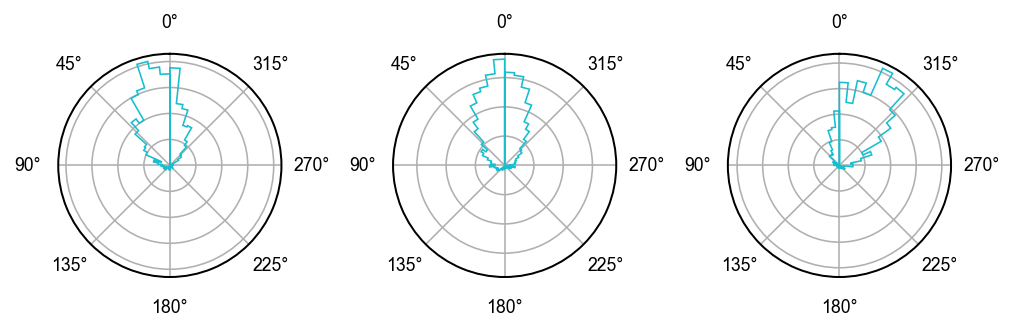

In [34]:
# plot the histogram of angles (relative to the goal) for preBMI (blue) running tasks for three animals
fig, ax = plt.subplots(1, 3, figsize=(8, 3), subplot_kw=dict(projection='polar'))

ax[0].hist(preBMI_angles1, bins=60, density=True, color='blue', alpha=1, edgecolor='C9', histtype='step');
ax[1].hist(preBMI_angles2, bins=60, density=True, color='blue', alpha=1, edgecolor='C9', histtype='step');
ax[2].hist(preBMI_angles3, bins=60, density=True, color='blue', alpha=1, edgecolor='C9', histtype='step');

for i in range(3):
    ax[i].set_yticklabels([])
    ax[i].set_rlabel_position(90)
    ax[i].set_theta_zero_location("N")
    
plt.subplots_adjust(wspace=0.5, hspace=0.3)